In [1]:
import sys
sys.path.append('../src/')

from simulations import generate_ideal_points

ideal_points, df, word_matrix, beta, label_coeffs = generate_ideal_points(
    num_politicians=10000,
    dim_ideal_points=1,
    num_covs=0,
    num_bills=1000,
    num_survey_questions=100,
    doc_length=100,
    vocab_size=500,
    label_type="regression",
    progress_bar=True
)

Surveys: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.94it/s]


In [2]:
from corpus import Corpus

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()  
vectorizer.fit(df["doc_clean"])

modalities = {
    "text": {
        "column": "doc_clean",
        "views": {
            "bow": {
                "type": "bow",
                "vectorizer": vectorizer
            }
        }
    },
    "vote": {
        "column": [f"vote_{i+1}" for i in range(500)],
        "views": {
            "responses": {
                "type": "vote"
            }
        }
    },
    "survey": {
        "column": [f"Q_{i+1}" for i in range(100)],
        "views": {
            "responses": {
                "type": "discrete_choice"
            }
        }
    }
}

full_dataset = Corpus(
    df,
    modalities=modalities
)

In [3]:
from models import IdealPointNN

encoder_args = {
    "text_bow": {
        "hidden_dims": [128,64],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    },
    "vote_responses": {
        "hidden_dims": [128,64],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    }
}

decoder_args = {
    "text_bow": {
        "hidden_dims": [],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    },
    "vote_responses": {
        "hidden_dims": [],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    }
}

m = IdealPointNN(
    ae_type="vae",
    vi_type="full_rank",
    fixed_prior=True,
    n_ideal_points=1,
    train_data=full_dataset,
    encoder_args=encoder_args,
    decoder_args=decoder_args,
    print_every_n_epochs=1,
    patience=1,
    w_prior=1,
    fusion="moe_average",
    kl_annealing_start=-1,
    kl_annealing_end=-1
)


Epoch   1	Mean Training Loss:7.1277541


Epoch   2	Mean Training Loss:7.0508873


Epoch   3	Mean Training Loss:7.0000472


Epoch   4	Mean Training Loss:6.9641329


Epoch   5	Mean Training Loss:6.9377597


Epoch   6	Mean Training Loss:6.8752547


Epoch   7	Mean Training Loss:6.7751232


Epoch   8	Mean Training Loss:6.7485947


Epoch   9	Mean Training Loss:6.7427255


Epoch  10	Mean Training Loss:6.7406935


Epoch  11	Mean Training Loss:6.7373203


Epoch  12	Mean Training Loss:6.7350685


Epoch  13	Mean Training Loss:6.7324217


Epoch  14	Mean Training Loss:6.7298024


Epoch  15	Mean Training Loss:6.7272711


Epoch  16	Mean Training Loss:6.7259808


Epoch  17	Mean Training Loss:6.7249103


Epoch  18	Mean Training Loss:6.7236143


Epoch  19	Mean Training Loss:6.7229306


Epoch  20	Mean Training Loss:6.7225365


Epoch  21	Mean Training Loss:6.7226148


Stopping at Epoch 21. Reverting to Epoch 20


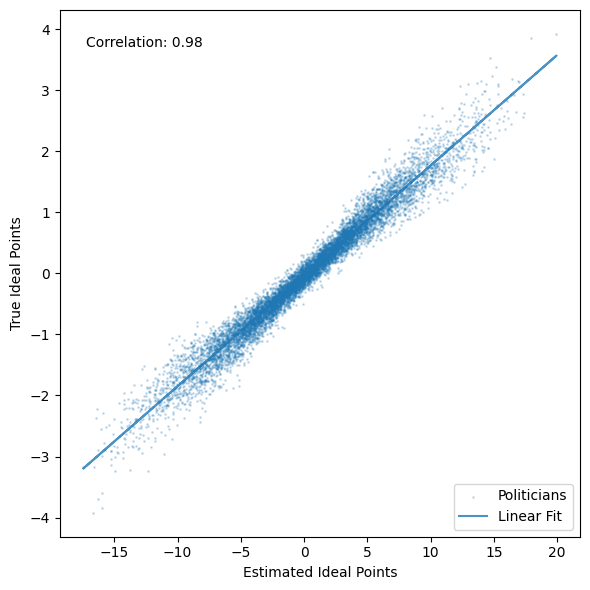

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Get estimated ideal points (shape: [N, 1])
estimated = m.get_ideal_points(
    full_dataset, 
    num_samples=30
)

# True ideal points from the simulation (shape: [N, D])
true = ideal_points[:, 0]  # Assuming 1D ideal points, take column 0

# Flatten for plotting
x = estimated.flatten()
y = true.flatten()  # Optional sign correction to align orientation

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, label='Politicians', s=1, alpha=0.2)

# Linear fit
coefficients = np.polyfit(x, y, 1)
fit_fn = np.poly1d(coefficients)
plt.plot(x, fit_fn(x), label='Linear Fit', alpha=0.8)

# Correlation coefficient
corr = np.corrcoef(x, y)[0, 1]

# Labels
plt.xlabel('Estimated Ideal Points')
plt.ylabel('True Ideal Points')
plt.legend()

# Correlation display
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}',
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')

# Layout and save
plt.tight_layout()
plt.show()

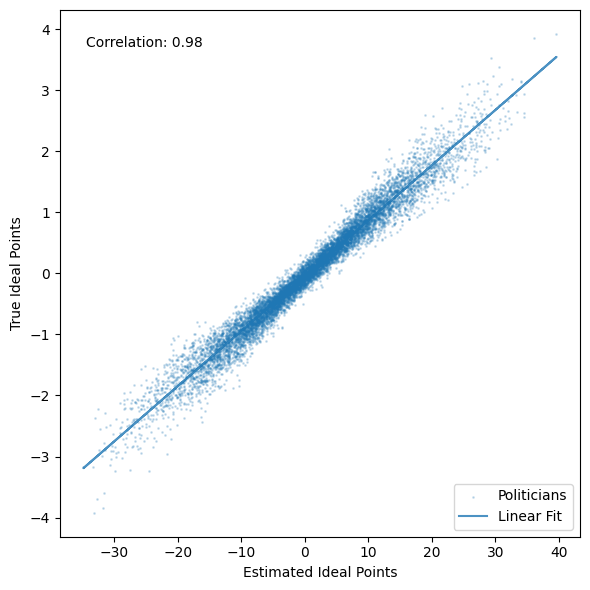

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Get estimated ideal points (shape: [N, 1])
estimated = m.get_ideal_points(
    full_dataset, 
    single_modality="text_bow", 
    num_samples=30
)

# True ideal points from the simulation (shape: [N, D])
true = ideal_points[:, 0]  # Assuming 1D ideal points, take column 0

# Flatten for plotting
x = estimated.flatten()
y = true.flatten()  # Optional sign correction to align orientation

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, label='Politicians', s=1, alpha=0.2)

# Linear fit
coefficients = np.polyfit(x, y, 1)
fit_fn = np.poly1d(coefficients)
plt.plot(x, fit_fn(x), label='Linear Fit', alpha=0.8)

# Correlation coefficient
corr = np.corrcoef(x, y)[0, 1]

# Labels
plt.xlabel('Estimated Ideal Points')
plt.ylabel('True Ideal Points')
plt.legend()

# Correlation display
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}',
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')

# Layout and save
plt.tight_layout()
plt.show()

In [6]:
# How much does each modality contribute (on average)?
# Text is much noisier, so the model puts much more weight on votes.

weights = m.get_modality_weights(full_dataset)
modality_names = list(m.encoder.encoders.keys())  # e.g., ['text_bow', 'vote_responses']

# Average contribution per modality
import pandas as pd

df_weights = pd.DataFrame(weights, columns=modality_names)
summary = pd.DataFrame({
    "mean": df_weights.mean(),
    "std": df_weights.std()
}).sort_values("mean", ascending=False)

print(summary)

                mean  std
text_bow         0.5  0.0
vote_responses   0.5  0.0


In [7]:
import numpy as np

# Get ideal point estimates and standard errors from your trained model
means, stds = m.get_ideal_points(full_dataset, num_samples=100, return_std=True)

# True ideal points (from simulation)
true = ideal_points[:, 0]  

# Compute 95% confidence intervals
lower = means.flatten() - 1.96 * stds.flatten()
upper = means.flatten() + 1.96 * stds.flatten()

95% CI coverage: 0.728


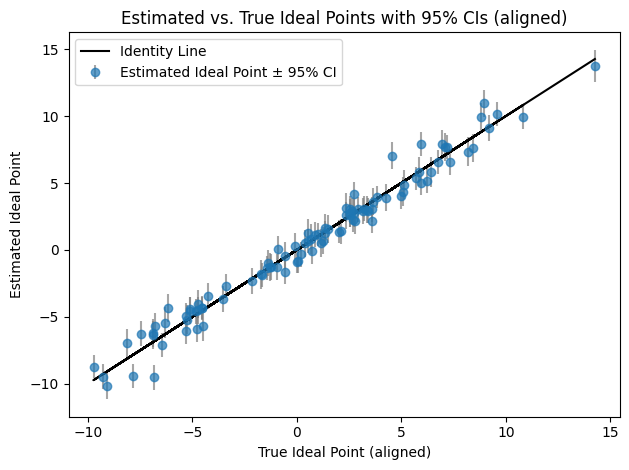

In [8]:
import numpy as np

# Flatten
est = means.flatten()
se  = stds.flatten()
tru = true.flatten()

# Affine alignment: est ≈ c*tru + d
c = np.cov(tru, est, bias=True)[0,1] / np.var(tru, ddof=0)
d = np.mean(est) - c*np.mean(tru)

true_aligned = c*tru + d  # same scale, shift, and possible sign as est

# CIs (unchanged) and coverage using aligned truth
lower = est - 1.96*se
upper = est + 1.96*se
coverage = np.mean((true_aligned >= lower) & (true_aligned <= upper))
print(f"95% CI coverage: {coverage:.3f}")

# Plot: TRUE (aligned) on x, ESTIMATE on y
import matplotlib.pyplot as plt
N_plot = 100
indices = np.random.choice(len(tru), size=min(N_plot, len(tru)), replace=False)

plt.errorbar(
    x=true_aligned[indices],
    y=est[indices],
    yerr=1.96*se[indices],
    fmt='o', ecolor='gray', alpha=0.7,
    label='Estimated Ideal Point ± 95% CI'
)
plt.plot(true_aligned[indices], true_aligned[indices], color='black', label='Identity Line')
plt.xlabel('True Ideal Point (aligned)')
plt.ylabel('Estimated Ideal Point')
plt.legend()
plt.title('Estimated vs. True Ideal Points with 95% CIs (aligned)')
plt.tight_layout()
plt.show()
